## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import scipy.io as sio
from characterDefinitions import getHandwritingCharacterDefinitions
from torchvision.models import resnet50
import numpy as np

/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Load the Dataset

In [2]:
topDirs = ['Datasets']
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']
charDef = getHandwritingCharacterDefinitions()

In [3]:
all_tensors = []
all_labels = []
for directory in dataDirs:
    
    mat = f'./Datasets/{directory}/singleLetters.mat'
    data = sio.loadmat(mat)
    ctr = 0
    for letter in charDef['charList']:
        t = torch.Tensor(data[f'neuralActivityCube_{letter}'])
        qty = t.shape[0]
        labels = torch.Tensor([ctr]*qty)
        ctr += 1
#         if t.shape[0] == 27:
        all_tensors.append(t)
        all_labels.append(labels)

tensor_data = torch.cat(all_tensors, dim=0)
tensor_data = np.repeat(tensor_data[..., np.newaxis], 3, -1).transpose(-1,-2).transpose(-2,-3)

# tensor_data = tensor_data.transpose(-1,0).transpose(-1,-2)
tensor_labels = torch.cat(all_labels).long()


In [ ]:
# tensor_data=rgb_data
tensor_data.shape

In [4]:
from torch.utils.data import random_split


dataset = TensorDataset(tensor_data, tensor_labels)
train_data, test_data = random_split(dataset, [3000, 627])
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [3]:
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        self.resnet = resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [5]:
# Step 4: Model Compilation
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model = MyCNN(31)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=model.to(device)

cuda:1


/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/jcbolo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_epochs = 100
batch_size = 32

In [8]:
for epoch in range(num_epochs):
    model.train()
    print(f'epoch {epoch}')
    for batch in train_dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels= labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)  # Add a channel dimension to the input
        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()
    
    # Step 6: Model Evaluation
    model.eval()
    with torch.no_grad():
        cumulative_accuracy = torch.tensor([]).to(device)
        for batch in test_dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            val_outputs = model(inputs).to(device)
            val_loss = criterion(val_outputs, labels).to(device)
            val_predictions = torch.argmax(val_outputs, dim=1).to(device)
            val_accuracy = (val_predictions == labels).float().to(device)
            cumulative_accuracy = torch.cat([cumulative_accuracy,val_accuracy], dim=0).to(device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {cumulative_accuracy.mean().item():.4f}")

epoch 0
Epoch 1/100, Validation Loss: 6.7950, Validation Accuracy: 0.0319
epoch 1
Epoch 2/100, Validation Loss: 3.5397, Validation Accuracy: 0.0303
epoch 2
Epoch 3/100, Validation Loss: 3.5326, Validation Accuracy: 0.0319
epoch 3
Epoch 4/100, Validation Loss: 3.5750, Validation Accuracy: 0.0319
epoch 4
Epoch 5/100, Validation Loss: 3.1110, Validation Accuracy: 0.0766
epoch 5
Epoch 6/100, Validation Loss: 2.9852, Validation Accuracy: 0.0989
epoch 6
Epoch 7/100, Validation Loss: 2.7643, Validation Accuracy: 0.2424
epoch 7
Epoch 8/100, Validation Loss: 1.3146, Validation Accuracy: 0.4609
epoch 8
Epoch 9/100, Validation Loss: 1.1424, Validation Accuracy: 0.5199
epoch 9
Epoch 10/100, Validation Loss: 0.6963, Validation Accuracy: 0.6268
epoch 10
Epoch 11/100, Validation Loss: 1.3679, Validation Accuracy: 0.5805
epoch 11
Epoch 12/100, Validation Loss: 0.7228, Validation Accuracy: 0.6316
epoch 12
Epoch 13/100, Validation Loss: 0.5852, Validation Accuracy: 0.6954
epoch 13
Epoch 14/100, Validati

In [10]:
torch.save(model.state_dict(), './resnet_single_chars_3.pth')

In [7]:
model.load_state_dict(torch.load('./resnet_single_chars_3.pth'))
sd = model.state_dict()
for k,v in sd.items():
    print("{:20s} {}".format(k, v.shape))

resnet.conv1.weight  torch.Size([64, 3, 7, 7])
resnet.bn1.weight    torch.Size([64])
resnet.bn1.bias      torch.Size([64])
resnet.bn1.running_mean torch.Size([64])
resnet.bn1.running_var torch.Size([64])
resnet.bn1.num_batches_tracked torch.Size([])
resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
resnet.layer1.0.bn1.weight torch.Size([64])
resnet.layer1.0.bn1.bias torch.Size([64])
resnet.layer1.0.bn1.running_mean torch.Size([64])
resnet.layer1.0.bn1.running_var torch.Size([64])
resnet.layer1.0.bn1.num_batches_tracked torch.Size([])
resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
resnet.layer1.0.bn2.weight torch.Size([64])
resnet.layer1.0.bn2.bias torch.Size([64])
resnet.layer1.0.bn2.running_mean torch.Size([64])
resnet.layer1.0.bn2.running_var torch.Size([64])
resnet.layer1.0.bn2.num_batches_tracked torch.Size([])
resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
resnet.layer1.0.bn3.weight torch.Size([256])
resnet.layer1.0.bn3.bias torch.Size([256])
resnet.layer1

In [26]:
model

MyCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [ ]:
# Transfer the PyTorch weights to TensorFlow model
for tf_layer, pytorch_layer in zip(model.layers, pytorch_weights['state_dict']):
    if 'custom_head' not in tf_layer.name:
        # Transfer the weights from feature extractor
        weights = pytorch_layer.data.cpu().numpy()
        tf_layer.set_weights([weights.transpose(2, 3, 1, 0)])
    else:
        # Transfer the weights from custom head
        weights = pytorch_layer.data.cpu().numpy()
        tf_layer.set_weights([weights, np.zeros(weights.shape[-1])])

In [24]:
import numpy
arr = model.resnet.conv1.weight.cpu().detach().numpy()
numpy.savetxt('resnet_conv1.csv', arr, delimiter=','

array([[[[ 2.39570648e-03, -8.82792175e-02, -1.22357428e-01, ...,
          -1.47268966e-01, -3.73165160e-02,  1.24705127e-02],
         [-6.42593279e-02, -2.46454831e-02,  5.00580072e-02, ...,
          -2.36102641e-02, -9.50335264e-02, -6.08040765e-02],
         [ 1.32150650e-01,  1.22301742e-01,  1.23382229e-02, ...,
           1.70994461e-01,  6.47596121e-02,  1.49737224e-01],
         ...,
         [ 4.34647426e-02, -2.79662665e-02, -1.08959787e-01, ...,
          -2.35900670e-01, -8.78423005e-02,  8.10506269e-02],
         [ 3.34529988e-02,  1.80578649e-01,  1.62574518e-02, ...,
          -1.06677897e-01, -7.18910098e-02,  9.56570581e-02],
         [-1.33777574e-01, -3.41585726e-02, -6.84483871e-02, ...,
           3.92765626e-02, -5.96567243e-03, -4.72027473e-02]],

        [[-2.93910149e-02, -9.15279537e-02, -8.31557289e-02, ...,
          -5.26368320e-02,  4.97390553e-02,  7.37579688e-02],
         [-7.61072263e-02, -1.16030769e-02,  1.03090703e-01, ...,
           1.33743003e

In [ ]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])


In [ ]:
backward_hook = model.resnet.layer4[-1].register_full_backward_hook(backward_hook)
forward_hook = model.resnet.layer4[-1].register_forward_hook(forward_hook)

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL


def gradCAM(model, example, class_, pth):
    x = model(example)
    criterion(x, torch.tensor([class_]).to(device)).backward()
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach().cpu())
    # Create a figure and plot the first image
    fig, ax = plt.subplots()
    ax.axis('off') # removes the axis markers

    # First plot the original image
    ax.imshow(to_pil_image(example.squeeze(0), mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest', extent=(0,example.shape[-1],example.shape[-2],0))

    # Show the plot
#     plt.show()
    plt.savefig(pth)
    return plt

In [ ]:
import os

root = './gradcam_images'
if not os.path.exists(root):
    os.mkdir(root)
    
for directory in dataDirs:
    
    mat = f'./Datasets/{directory}/singleLetters.mat'
    data = sio.loadmat(mat)
    class_ctr = 0
    for letter in charDef['charList']:
        t = torch.Tensor(data[f'neuralActivityCube_{letter}'])
        ex_ctr=0
        if not os.path.exists("{}/{}".format(root,letter)):
            os.mkdir("{}/{}".format(root,letter))
        for ex in t:
            pth = "{}/{}/{}.png".format(root,letter,ex_ctr)
            ex = np.repeat(ex[..., np.newaxis], 3, -1).transpose(-1,-2).transpose(-2,-3).unsqueeze(0).to(device)
            plt=gradCAM(model,ex,class_ctr, pth)
#             plt.savefig("{}/{}/{}.png".format(root,letter,ex_ctr))
            
            ex_ctr += 1
        class_ctr += 1


In [ ]:
backward_hook.remove()
forward_hook.remove()

31


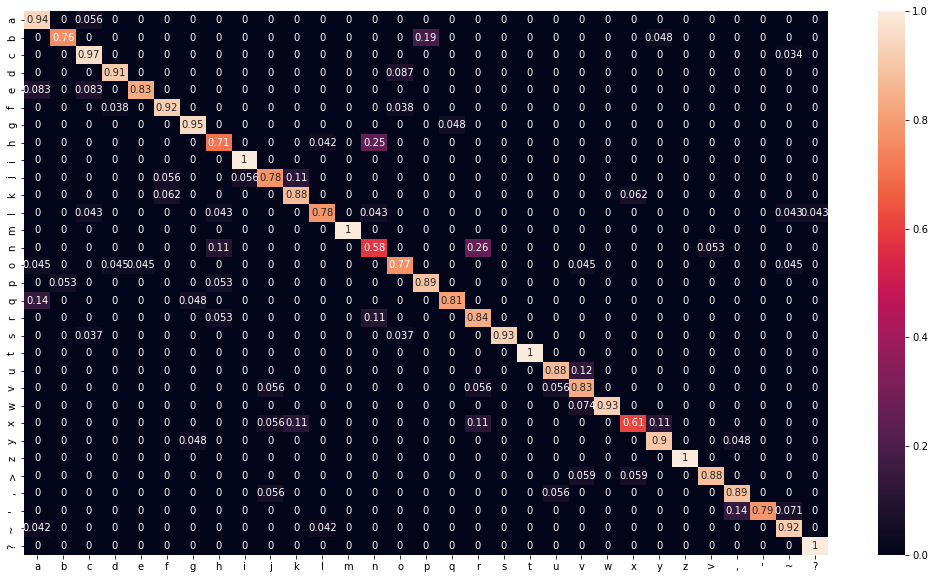

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = charDef['charList']
classes = classes[:-5] + ['>', ',', '\'', '~', '?']
print(len(classes))
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24//1.3,14//1.3))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')